Conda environment: Python 3.9.21
Run: !pip install -r requirements.txt
The requirements.txt file includes all necessary libraries.

### 1.Feature Extraction Using VGG

In [ ]:
from os import listdir
from pickle import dump
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model


# Extract features from each image in the specified directory
def extract_features(directory):
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    print(model.summary())
    features = dict()
    for name in listdir(directory):
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature
        print('>%s' % name)
    
    return features


directory = './Images/Images'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# Save the features dictionary to a pickle file
dump(features, open('features1.pkl', 'wb'))


### 2.Image Captioning

In [2]:
import string

# load doc into memory
def load_doc(filename):
	file = open(filename, 'r')     
	text = file.read()            
	file.close()                  
	return text

# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):       
		tokens = line.split()            
		if len(line) < 2:
			continue                    
		image_id, image_desc = tokens[0], tokens[1:]       
		image_id = image_id.split('.')[0]                   
		image_desc = ' '.join(image_desc)                   
		if image_id not in mapping:                         
			mapping[image_id] = list()
		mapping[image_id].append(image_desc)                
	return mapping

def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)     
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()                               
			desc = [word.lower() for word in desc]            
			desc = [w.translate(table) for w in desc]         
			desc = [word for word in desc if len(word)>1]     
			desc = [word for word in desc if word.isalpha()]  
			desc_list[i] =  ' '.join(desc)                   

# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	all_desc = set()                              
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

#Enter the the commentary text file with path    
filename = 'N_token Ind vs Aus.txt'
doc = load_doc(filename)                         
descriptions = load_descriptions(doc)            
print('Loaded: %d ' % len(descriptions))          
clean_descriptions(descriptions)                 
vocabulary = to_vocabulary(descriptions)         
print('Vocabulary Size: %d' % len(vocabulary))      
save_descriptions(descriptions, 'descriptions1.txt')    


Loaded: 4168 
Vocabulary Size: 440


### 3.Loading Datasets and Image Features

In [ ]:
from pickle import load


# Load file content into memory
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text


# Load predefined photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)


# Load cleaned descriptions into memory
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions


# Load photo features
def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))
    # Filter features to include only those with image IDs in the dataset
    features = {k: all_features[k] for k in dataset}
    return features


# Load the training dataset
filename = 'N_token Ind vs Aus.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

# Load training descriptions
train_descriptions = load_clean_descriptions('descriptions1.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

# Load training image features
train_features = load_photo_features('features1.pkl', train)
print('Photos: train=%d' % len(train_features))

Dataset: 4168
Descriptions: train=4168
Photos: train=4168


### 4.Model Architecture and Training

In [ ]:
# Import necessary libraries
from numpy import array
from pickle import load
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


# Load file content into memory
def load_doc(filename):
    file = open(filename, 'r')  # Open file in read mode
    text = file.read()  # Read all content of the file
    file.close()  # Close the file
    return text


# Load predefined photo identifiers
def load_set(filename):
    doc = load_doc(filename)  # Load document content
    dataset = list()  # Create a list to store the dataset
    for line in doc.split('\n'):  # Process each line in the document
        if len(line) < 1:  # Skip empty lines
            continue
        identifier = line.split('.')[0]  # Extract the image identifier
        dataset.append(identifier)  # Add the identifier to the dataset
    return set(dataset)  # Return a set of identifiers


# Load cleaned descriptions
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)  
    descriptions = dict()  
    for line in doc.split('\n'):  
        tokens = line.split()  
        image_id, image_desc = tokens[0], tokens[1:]  
        if image_id in dataset:  
            if image_id not in descriptions:  
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'  
            descriptions[image_id].append(desc)  
    return descriptions


# Load photo features
def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))  
    features = {k: all_features[k] for k in dataset} 
    return features 

# Convert cleaned descriptions dictionary to a list of descriptions
def to_lines(descriptions):
    all_desc = list()  
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]  
    return all_desc


# Create a tokenizer based on descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)  
    tokenizer = Tokenizer()  
    tokenizer.fit_on_texts(lines)  
    return tokenizer  

# Calculate the maximum length of descriptions
def max_length(descriptions):
    lines = to_lines(descriptions)  
    return max(len(d.split()) for d in lines)  


# Create sequences, input sequences, and output words
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    X1, X2, y = list(), list(), list()  
    for key, desc_list in descriptions.items():  
        for desc in desc_list:  
            seq = tokenizer.texts_to_sequences([desc])[0]  
            for i in range(1, len(seq)):  
                in_seq, out_seq = seq[:i], seq[i]  
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]  
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]  
                X1.append(photos[key][0])  
                X2.append(in_seq)  
                y.append(out_seq)  
    return array(X1), array(X2), array(y)  


# Define the image captioning model
def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(4096,))  
    fe1 = Dropout(0.5)(inputs1)  
    fe2 = Dense(256, activation='relu')(fe1)  

    # Sequence model
    inputs2 = Input(shape=(max_length,))  
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)  
    se2 = Dropout(0.5)(se1)  
    se3 = LSTM(256)(se2)  

    # Decoder model
    decoder1 = add([fe2, se3])  
    decoder2 = Dense(256, activation='relu')(decoder1)  
    outputs = Dense(vocab_size, activation='softmax')(decoder2)  

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)  
    model.compile(loss='categorical_crossentropy', optimizer='adam')  
    print(model.summary())  
    plot_model(model, to_file='model.png', show_shapes=True)  
    return model  


# Load training dataset
filename = './Ntrain.txt'  
train = load_set(filename)  
print('Dataset: %d' % len(train))  
train_descriptions = load_clean_descriptions('descriptions1.txt', train)  
print('Descriptions: train=%d' % len(train_descriptions))  
train_features = load_photo_features('features1.pkl', train) 
print('Photos: train=%d' % len(train_features))  
tokenizer = create_tokenizer(train_descriptions)  
vocab_size = len(tokenizer.word_index) + 1  
print('Vocabulary Size: %d' % vocab_size)  
max_length = max_length(train_descriptions)  
print('Description Length: %d' % max_length)  
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size) 


# Load development dataset
filename = './Ntest.txt'  
test = load_set(filename)  
print('Dataset: %d' % len(test))  
test_descriptions = load_clean_descriptions('descriptions1.txt', test)  
print('Descriptions: test=%d' % len(test_descriptions))  
test_features = load_photo_features('features1.pkl', test)  
print('Photos: test=%d' % len(test_features))  
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)  


# Train the model
model = define_model(vocab_size, max_length)  
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'  
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min') 

# Train the model and save history
history = model.fit([X1train, X2train], ytrain,
                    epochs=5, verbose=1,
                    callbacks=[checkpoint],
                    validation_data=([X1test, X2test], ytest))

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('loss_curve.png')  
plt.show()  


Dataset: 2500
Descriptions: train=2500
Photos: train=2500
Vocabulary Size: 426
Description Length: 25
Dataset: 834
Descriptions: test=834
Photos: test=834
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 256)      109056      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (Non

KeyboardInterrupt: 

### 5.Generating Image Captions

In [ ]:
# Return the corresponding word for a given integer
def word_for_id(integer, tokenizer):
    # Iterate through the tokenizer's word index
    for word, index in tokenizer.word_index.items():
        # If the index matches the given integer
        if index == integer:
            return word
    return None  # Return None if no corresponding word is found


# Generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text  


### 6.Model Evaluation

In [ ]:
# Evaluate model performance
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()  # Initialize lists to store actual and predicted descriptions

    # Iterate over each image in the descriptions dictionary
    for key, desc_list in descriptions.items():
        # Generate a description for the image
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # Process and store the actual descriptions
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())

    # Calculate BLEU scores
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


from tensorflow.keras.models import load_model
from numpy import argmax
from pickle import load
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu

from tensorflow.keras.layers import Lambda
import tensorflow as tf


# Calculate the maximum description length
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)


# Prepare the tokenizer for the training set
# Load the training dataset
filename = 'Ntrain.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

# Load training descriptions
train_descriptions = load_clean_descriptions('descriptions1.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

# Prepare the tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

# Determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)


# Prepare the test set
# Load the test dataset
filename = 'Ntest.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

# Load test descriptions
test_descriptions = load_clean_descriptions('descriptions1.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

# Load test image features
test_features = load_photo_features('features1.pkl', test)
print('Photos: test=%d' % len(test_features))


# Load the model
# Specify the path to the model with the lowest loss
model = load_model('./modelF/model-ep005-loss0.438-val_loss0.509.h5',
                  custom_objects={'NotEqual': Lambda(lambda x: tf.not_equal(x, 0))})
# Evaluate the model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)


Dataset: 2500
Descriptions: train=2500
Vocabulary Size: 426
Description Length: 25
Dataset: 834
Descriptions: test=834
Photos: test=834
BLEU-1: 0.880229
BLEU-2: 0.817585
BLEU-3: 0.794003
BLEU-4: 0.733593


### 7.Loading and Processing Image Description Data

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from pickle import dump


# Load file content into memory
def load_doc(filename):
    file = open(filename, 'r')  # Open file in read mode
    text = file.read()  # Read all content of the file
    file.close()  # Close the file
    return text


# Load predefined photo identifiers
def load_set(filename):
    doc = load_doc(filename)  # Load document content
    dataset = list()  # Create a list to store the dataset
    for line in doc.split('\n'):  # Process each line in the document
        if len(line) < 1:  # Skip empty lines
            continue
        identifier = line.split('.')[0]  # Extract the image identifier
        dataset.append(identifier)  # Add the identifier to the dataset
    return set(dataset)  # Return a set of identifiers


# Load cleaned descriptions into memory
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)  # Load the descriptions document
    descriptions = dict()  # Create a dictionary to store descriptions
    for line in doc.split('\n'):  # Process each line in the document
        tokens = line.split()  # Split the line by whitespace
        image_id, image_desc = tokens[0], tokens[1:]  # Separate ID and description
        if image_id in dataset:  # Only process image IDs present in the dataset
            if image_id not in descriptions:  # Initialize list if ID not in descriptions
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'  # Add start and end tokens
            descriptions[image_id].append(desc)  # Store the description in the dictionary
    return descriptions


# Convert cleaned descriptions dictionary to a list of descriptions
def to_lines(descriptions):
    all_desc = list()  # Create a list to store all descriptions
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]  # Add each description to the list
    return all_desc


# Create a tokenizer based on descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)  # Get all descriptions
    tokenizer = Tokenizer()  # Instantiate the tokenizer
    tokenizer.fit_on_texts(lines)  # Train the tokenizer
    return tokenizer  # Return the trained tokenizer


# Load the training dataset
filename = 'Ntrain.txt'
train = load_set(filename)  # Load training dataset
print('Dataset: %d' % len(train))  # Print dataset size

# Load training descriptions
train_descriptions = load_clean_descriptions('descriptions1.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))  # Print number of descriptions

# Prepare and save the tokenizer
tokenizer = create_tokenizer(train_descriptions)  # Create tokenizer
dump(tokenizer, open('tokenizer1.pkl', 'wb'))  # Save tokenizer to file


Dataset: 2500
Descriptions: train=2500


### 8. Model Results Visualization

Loading VGG16 model for feature extraction...
VGG16 model loaded successfully.
Loading Tokenizer from: tokenizer1.pkl...
Tokenizer loaded successfully.
Loading image captioning model from: ./modelF/model-ep005-loss0.438-val_loss0.509.h5...
Image captioning model loaded successfully.
Successfully loaded descriptions for 4168 images.

--- Processing images in directory './test' ---

Processing image 1/11: 1_0_1.png


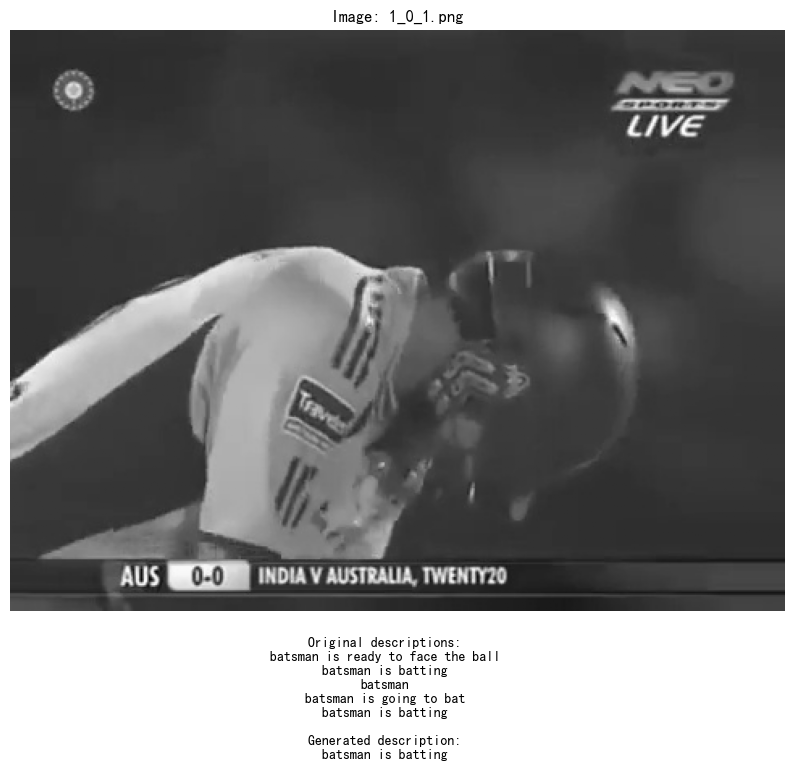

Original descriptions: batsman is ready to face the ball, batsman is batting, batsman, batsman is going to bat, batsman is batting
Generated description: batsman is batting

Processing image 2/11: 1_1_44.png


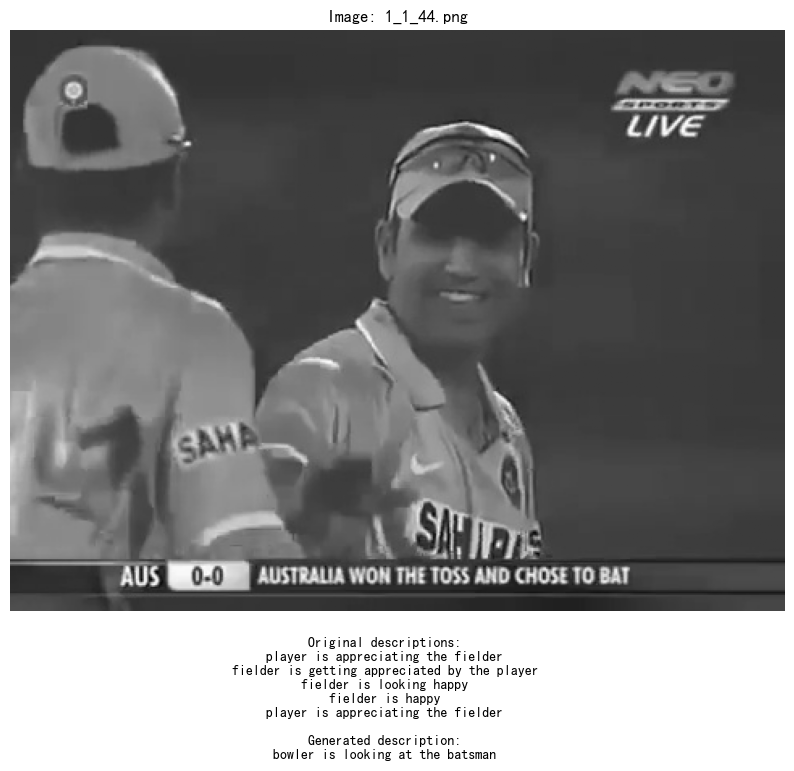

Original descriptions: player is appreciating the fielder, fielder is getting appreciated by the player, fielder is looking happy, fielder is happy, player is appreciating the fielder
Generated description: bowler is looking at the batsman

Processing image 3/11: 1_1_9.png


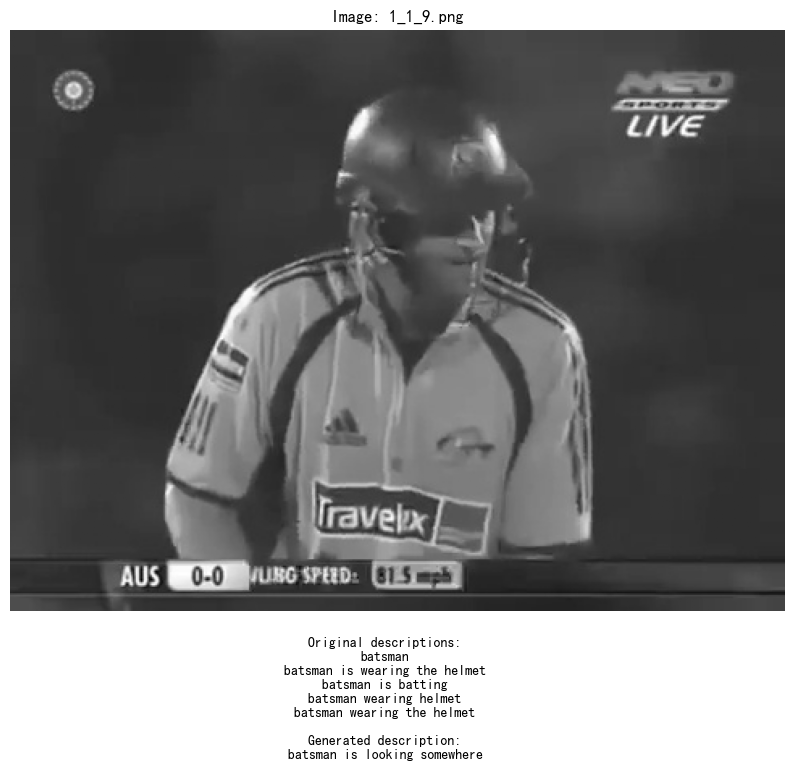

Original descriptions: batsman, batsman is wearing the helmet, batsman is batting, batsman wearing helmet, batsman wearing the helmet
Generated description: batsman is looking somewhere

Processing image 4/11: 1_2_14.png


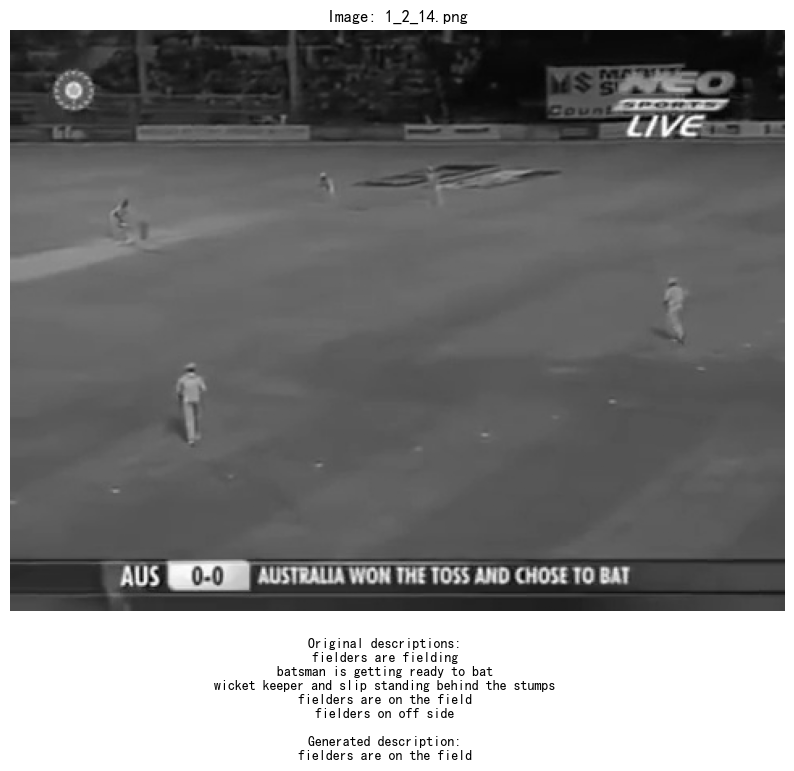

Original descriptions: fielders are fielding, batsman is getting ready to bat, wicket keeper and slip standing behind the stumps, fielders are on the field, fielders on off side
Generated description: fielders are on the field

Processing image 5/11: 1_3_22.png


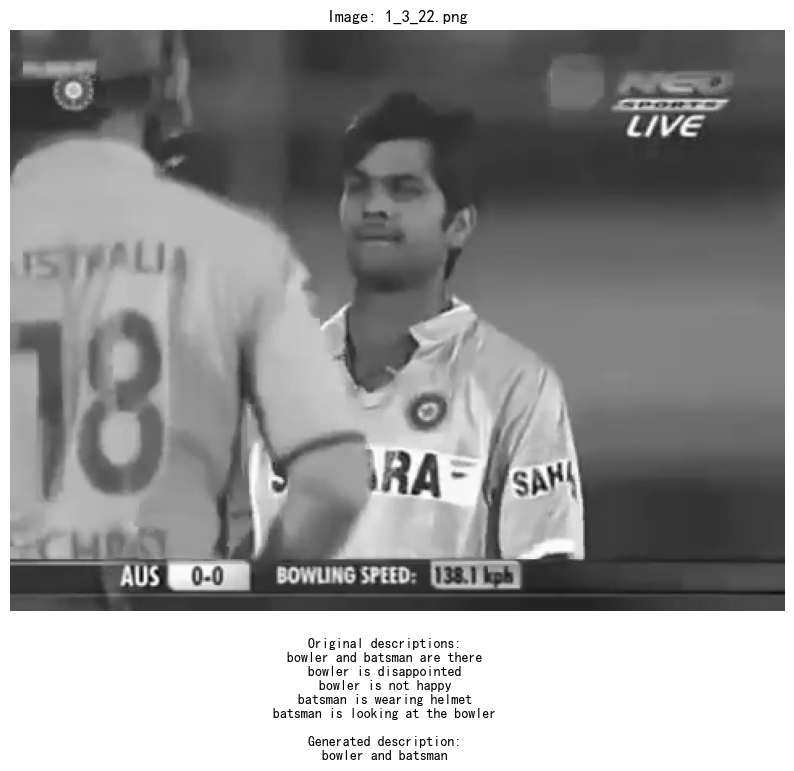

Original descriptions: bowler and batsman are there, bowler is disappointed, bowler is not happy, batsman is wearing helmet, batsman is looking at the bowler
Generated description: bowler and batsman

Processing image 6/11: result_1_1_9.png


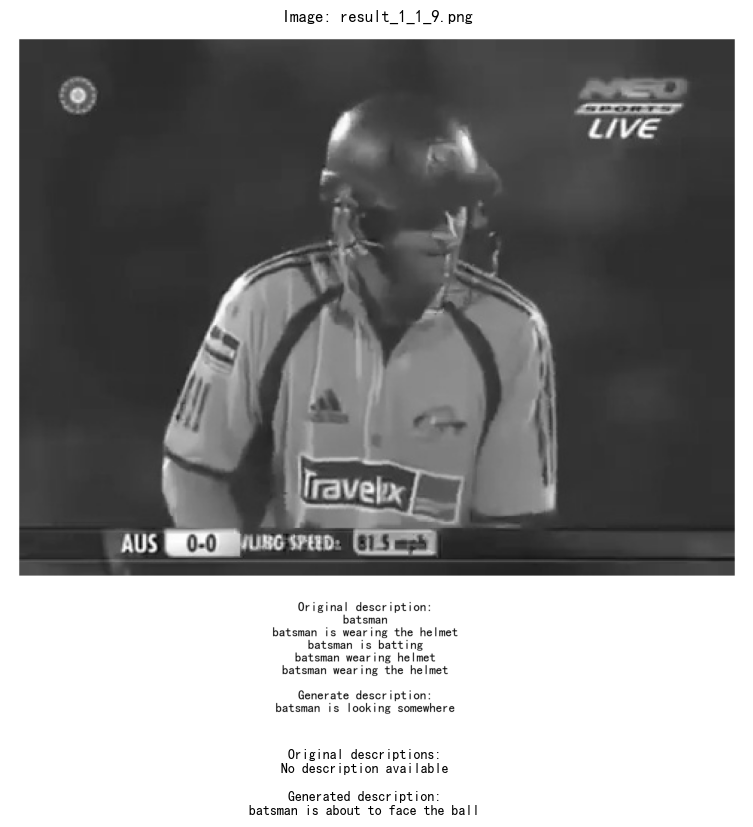

Original descriptions: No description available
Generated description: batsman is about to face the ball

Processing image 7/11: result_1_3_22.png


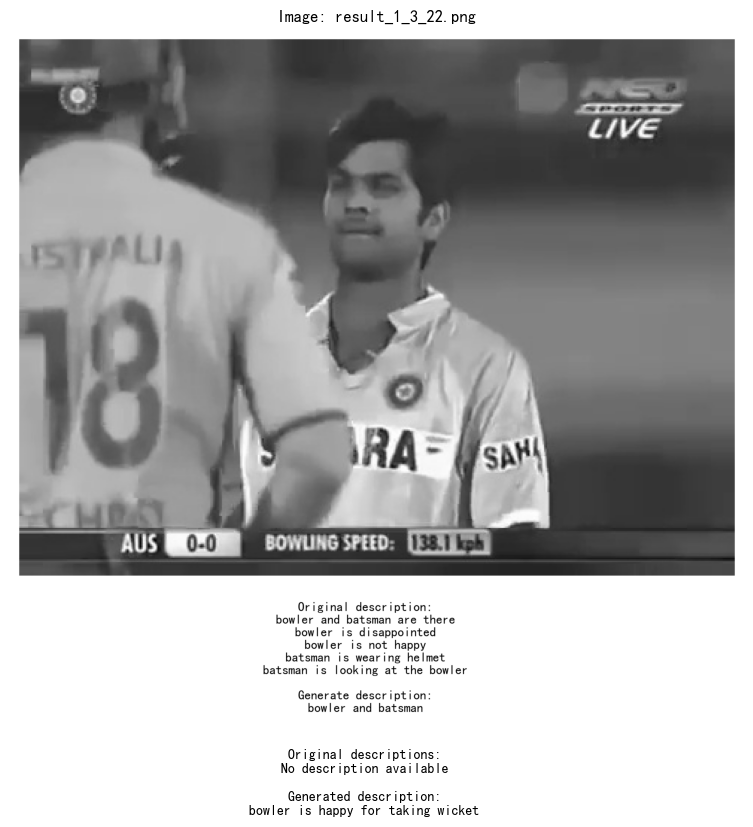

Original descriptions: No description available
Generated description: bowler is happy for taking wicket

Processing image 8/11: result_text.jpg


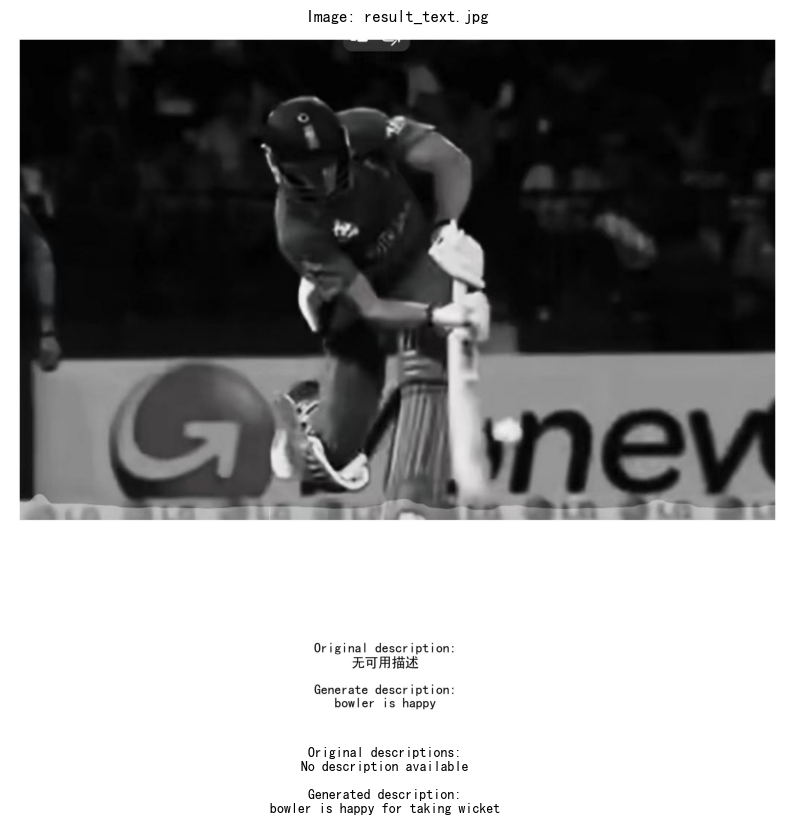

Original descriptions: No description available
Generated description: bowler is happy for taking wicket

Processing image 9/11: result_text2.jpg


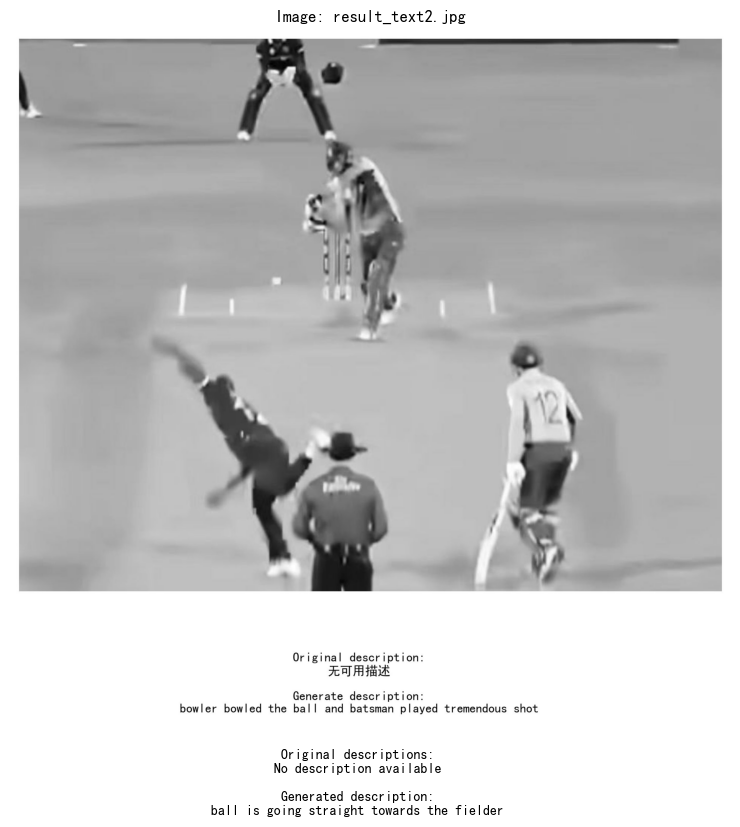

Original descriptions: No description available
Generated description: ball is going straight towards the fielder

Processing image 10/11: text.jpg


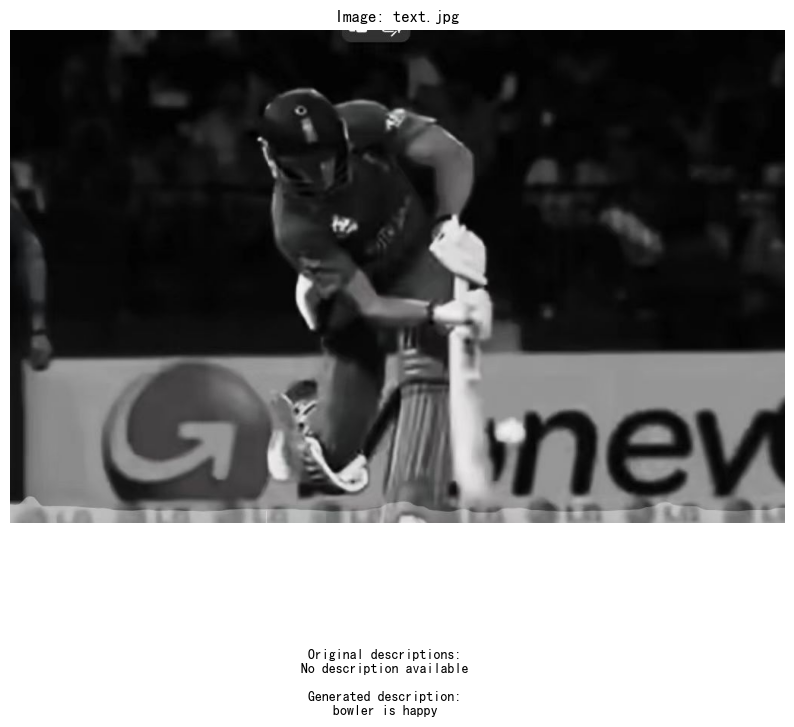

Original descriptions: No description available
Generated description: bowler is happy

Processing image 11/11: text2.jpg


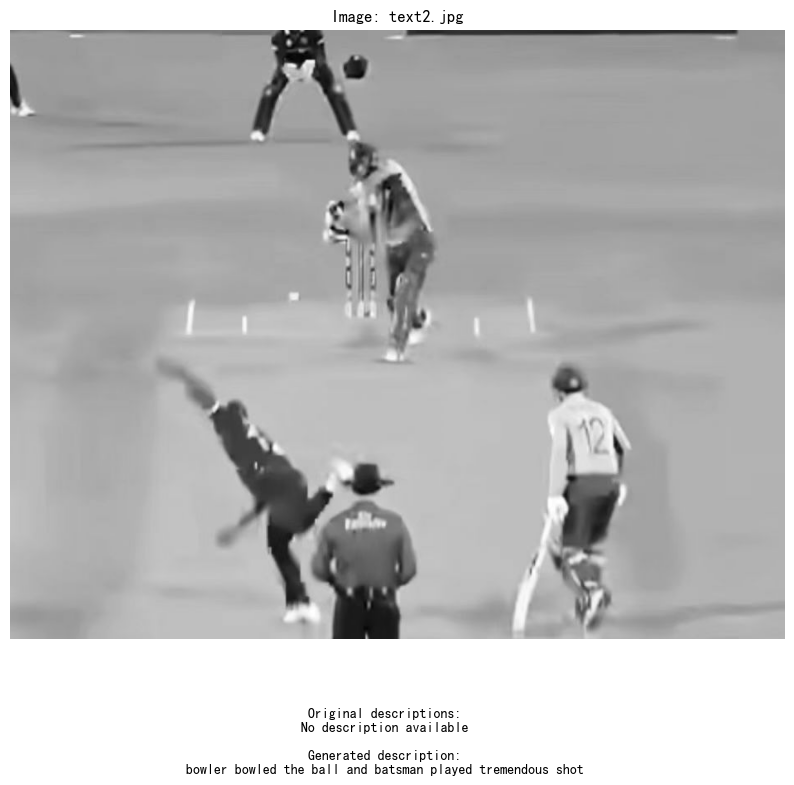

Original descriptions: No description available
Generated description: bowler bowled the ball and batsman played tremendous shot

--- All images processed ---


In [1]:
import os
from pickle import load
from numpy import argmax
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt

# Configure matplotlib for Chinese font support (retained for compatibility)
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'KaiTi', 'FangSong']
plt.rcParams['axes.unicode_minus'] = False

# --- Load VGG16 model globally for feature extraction ---
print("Loading VGG16 model for feature extraction...")
try:
    vgg_base_model = VGG16()
    vgg_feature_extractor_global = Model(inputs=vgg_base_model.inputs, outputs=vgg_base_model.layers[-2].output)
    print("VGG16 model loaded successfully.")
except Exception as e:
    print(f"Failed to load VGG16 model: {e}")
    exit()

# --- Feature extraction function ---
def extract_features_efficient(filename, loaded_vgg_model):
    try:
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = loaded_vgg_model.predict(image, verbose=0)
        return feature
    except Exception as e:
        print(f"Error extracting features for image '{filename}': {e}")
        return None

# --- Map integer to word ---
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# --- Generate description for an image ---
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

# --- Clean generated description text ---
def clean_generated_description(raw_description):
    temp_desc = raw_description
    if temp_desc.startswith('startseq '):
        temp_desc = temp_desc[len('startseq '):]
    elif temp_desc.startswith('startseq'):
        temp_desc = temp_desc[len('startseq'):]
    
    if temp_desc.endswith(' endseq'):
        temp_desc = temp_desc[:-len(' endseq')]
    elif temp_desc.endswith('endseq'):
        temp_desc = temp_desc[:-len('endseq')]
    
    return temp_desc.strip()

# --- Load descriptions from file ---
def load_descriptions(desc_file_path):
    """Load descriptions from a file."""
    descriptions = {}
    try:
        with open(desc_file_path, 'r') as file:
            for line in file:
                parts = line.strip().split(' ', 1)
                if len(parts) < 2:
                    continue
                img_name, desc = parts[0], parts[1]
                img_base = img_name.split('.')[0]  # Remove file extension
                if img_base not in descriptions:
                    descriptions[img_base] = []
                descriptions[img_base].append(desc)
        print(f"Successfully loaded descriptions for {len(descriptions)} images.")
        return descriptions
    except Exception as e:
        print(f"Failed to load descriptions file: {e}")
        return {}

# --- Load pre-trained models ---
TOKENIZER_PATH = 'tokenizer1.pkl'
MODEL_PATH = './modelF/model-ep005-loss0.438-val_loss0.509.h5'
MAX_LENGTH_CAPTION = 25
DESCRIPTIONS_FILE = 'descriptions1.txt'  # Path to descriptions file

print(f"Loading Tokenizer from: {TOKENIZER_PATH}...")
try:
    tokenizer_global = load(open(TOKENIZER_PATH, 'rb'))
    print("Tokenizer loaded successfully.")
except FileNotFoundError:
    print(f"Error: Tokenizer file '{TOKENIZER_PATH}' not found.")
    exit()
except Exception as e:
    print(f"Error loading Tokenizer: {e}")
    exit()

print(f"Loading image captioning model from: {MODEL_PATH}...")
try:
    caption_model_global = load_model(MODEL_PATH)
    print("Image captioning model loaded successfully.")
except FileNotFoundError:
    print(f"Error: Model file '{MODEL_PATH}' not found.")
    exit()
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Load original descriptions
descriptions_dict = load_descriptions(DESCRIPTIONS_FILE)

# --- Process images in a directory ---
def process_images_in_directory(directory_path, 
                              vgg_fe_model, 
                              caption_gen_model, 
                              tokenizer_obj, 
                              max_len,
                              descriptions_dict):
    if not os.path.isdir(directory_path):
        print(f"Error: Directory '{directory_path}' does not exist.")
        return

    supported_extensions = ('.png', '.jpg', '.jpeg')
    image_files = [f for f in os.listdir(directory_path) 
                  if f.lower().endswith(supported_extensions)]

    if not image_files:
        print(f"No supported image files found in directory '{directory_path}'.")
        return

    print(f"\n--- Processing images in directory '{directory_path}' ---")
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(directory_path, img_file)
        print(f"\nProcessing image {i+1}/{len(image_files)}: {img_file}")

        # Get original descriptions
        img_base = os.path.splitext(img_file)[0]
        original_descs = descriptions_dict.get(img_base, ["No description available"])
        
        # Extract features
        features = extract_features_efficient(img_path, vgg_fe_model)
        if features is None:
            print(f"Skipping image '{img_file}'")
            continue

        # Generate description
        raw_desc = generate_desc(caption_gen_model, tokenizer_obj, features, max_len)
        cleaned_desc = clean_generated_description(raw_desc)

        # Display results
        try:
            plt.figure(figsize=(10, 9))
            plt.imshow(plt.imread(img_path))
            plt.title(f"Image: {img_file}", fontsize=12)
            plt.axis('off')
            
            # Add text descriptions
            desc_text = "Original descriptions:\n" + "\n".join(original_descs) + "\n\nGenerated description:\n" + cleaned_desc
            plt.figtext(0.5, 0.01, desc_text, wrap=True, 
                       horizontalalignment='center', fontsize=10)
            plt.show()
            
            print(f"Original descriptions: {', '.join(original_descs)}")
            print(f"Generated description: {cleaned_desc}")
        except Exception as e:
            print(f"Error displaying image: {e}")
    
    print("\n--- All images processed ---")

# --- Execute processing ---
TARGET_DIR = './test'
process_images_in_directory(TARGET_DIR, 
                           vgg_feature_extractor_global, 
                           caption_model_global, 
                           tokenizer_global, 
                           MAX_LENGTH_CAPTION,
                           descriptions_dict)
